In [1]:
# %pip install great-expectations
# %pip install openpyxl

# Ratepay Analysis
This notebook contain the implementation of the solution to the tasks. Due to lack of time, there are lot of thing I would like to do but I was not able to do.  

## Task 1 
Share 3-5 insights about the dataset. What quality gates would you recommend to improve data
quality?

### Data Quality Gate
1. Missing Value Analysis - Calculate the percentage of missing values(NAN values): For each column, identify the proportion of missing values to decide on appropriate handling strategies.
2. Invalid Value Check - Ensure that columns like REGISTRATION_STATE_CGNDE contain only valid state codes and not invalid values like ??, 32, or **.
3. test_schema_validation:
    - Test schema validation: Use tools like Great Expectations to ensure columns such as FIRST_PURCHASE and LAST_PURCHASE are of datetime64 type.

    - Validate data types: Ensure all columns have the correct data types, such as numeric types for purchase-related fields and categorical types for PREFERRED_DEVICE.

4. test_uniqueness_check: Used great expectation the check uniqueness of columns like "CUSTOMER_ID"
5. test_hour_values : Check if "MOST_COMMON_HOUR_OF_THE_DAY_TO_PURCHASE" is valid that is between 0 - 23
6. test_weekdays_values : Check if "MOST_COMMON_WEEKDAY_TO_PURCHASE" is valid that is between 1 - 7
7. Platform purchase validation: Check if the sum of WEB_PURCHASES, IOS_PURCHASES, and ANDROID_PURCHASES equals the total PURCHASE_COUNT_DELIVERY.
8. Purchase catergories purchase validation: Verify that the sum of MISC_PURCHASES, HOME_PURCHASES, COSMETICS_PURCHASES, and FASHION_PURCHASES matches PURCHASE_TOTAL_EUR.
9. Investigate FIRST_PURCHASE and FIRST_PURCHASE
    - check date format
    - check invalid date
    - Date consistency checks: Ensure that FIRST_PURCHASE dates are earlier than or equal to LAST_PURCHASE dates.
10. Payment method validation: If HAS_VALID_PAYMENT_METHOD is True, ensure that PURCHASE_COUNT_DELIVERY is greater than zero.

## Data Cleaning 
Clean the data based on the quality gates above 

### Task 2
How would you model the data to report
1. Purchase trends

   a. Hour of the day

   b. Day of the week

   c. Days between first and last purchase

   d. Purchase value

   e. Average Order Value
2. Identify cohort of customers who are:

   a. Least likely to purchase in the following month.

   b. Most likely to purchase a marketing campaign.


In [35]:
### Data Quality Gate

In [36]:
# Importing libraries required for data analysis and visualization
import os
import pandas as pd
import matplotlib.pyplot as plt
import great_expectations as ge

In [37]:
# Setting pandas display options to show all rows, columns, and adjust the display width.
pd.set_option("display.max_rows", None)       # Display all rows in the DataFrame without truncation.
pd.set_option("display.max_columns", None)    # Display all columns in the DataFrame without truncation.
pd.set_option("display.width", None)          # Adjust the display width to fit the content, avoiding line breaks.

In [38]:
file_path = "/Users/robert/repos/private_repos/ratepay/resources/data/Case Study Dataset.xlsx"

In [39]:
# Loading the dataset from an Excel file into a pandas DataFrame.
raw_dataset = pd.read_excel(file_path)

In [40]:
raw_dataset.head(10)

,REGISTRATION_DATE,REGISTRATION_STATE_CGNDE,PURCHASE_COUNT_DELIVERY,FIRST_PURCHASE,LAST_PURCHASE,CUSTOMER_ID,MISC_PURCHASES,HOME_PURCHASES,COSMETICS_PURCHASES,FASHION_PURCHASES,PURCHASE_TOTAL_EUR,DISTINCT_PURCHASE_COUNT,PREFERRED_DEVICE,IOS_PURCHASES,WEB_PURCHASES,ANDROID_PURCHASES,HAS_VALID_PAYMENT_METHOD,MOST_COMMON_HOUR_OF_THE_DAY_TO_PURCHASE,MOST_COMMON_WEEKDAY_TO_PURCHASE,AVG_DAYS_BETWEEN_PURCHASES,AVERAGE_DELIVERY_DISTANCE_KMS
0,2021-09-01,BER,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,ios,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN
1,2021-09-01,FRA,1.0,2022-09-02 00:00:00,2022-09-02 00:00:00,2,0.0,1.0,0.0,0.0,38.456,1.0,android,0.0,0.0,1.0,False,23.0,2.0,NaN,6.853
2,2021-09-01,BER,19.0,2021-12-10 00:00:00,2022-05-25 00:00:00,3,0.0,4.0,1.0,14.0,631.488,9.0,android,0.0,19.0,0.0,True,21.0,2.0,9.0,6.559
3,2021-09-01,FRA,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN,android,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN
4,2021-09-01,MUC,NaN,NaN,NaN,5,NaN,NaN,NaN,NaN,NaN,NaN,android,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN
5,2021-09-01,FRA,NaN,NaN,NaN,6,NaN,NaN,NaN,NaN,NaN,NaN,android,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN
6,2021-09-01,BER,NaN,NaN,NaN,7,NaN,NaN,NaN,NaN,NaN,NaN,ios,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN
7,2021-09-01,FRA,1.0,2022-10-14 00:00:00,2022-10-14 00:00:00,8,0.0,0.0,1.0,0.0,19.228,1.0,android,0.0,0.0,1.0,True,5.0,1.0,NaN,1.251
8,2021-09-01,FRA,NaN,NaN,NaN,9,NaN,NaN,NaN,NaN,NaN,NaN,android,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN
9,2021-09-01,FRA,NaN,NaN,NaN,10,NaN,NaN,NaN,NaN,NaN,NaN,android,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN


In [41]:
# Displaying a concise summary of the dataset, including the number of non-null entries, column data types, and memory usage.
raw_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21428 entries, 0 to 21427
Data columns (total 21 columns):
 #   Column                                   Non-Null Count  Dtype         
---  ------                                   --------------  -----         
 0   REGISTRATION_DATE                        21428 non-null  datetime64[ns]
 1   REGISTRATION_STATE_CGNDE                 21427 non-null  object        
 2   PURCHASE_COUNT_DELIVERY                  11973 non-null  float64       
 3   FIRST_PURCHASE                           11909 non-null  object        
 4   LAST_PURCHASE                            11972 non-null  object        
 5   CUSTOMER_ID                              21428 non-null  int64         
 6   MISC_PURCHASES                           11973 non-null  float64       
 7   HOME_PURCHASES                           11973 non-null  float64       
 8   COSMETICS_PURCHASES                      11973 non-null  float64       
 9   FASHION_PURCHASES                      

### 1. Missing Value Analysis

In [42]:
# Calculate the percentage of NaN values in each column
nan_percentage = round(raw_dataset.isna().mean() * 100, 2)

# Convert the Series to a DataFrame and rename the column
nan_percentage_df = nan_percentage.reset_index()
nan_percentage_df.columns = ['Column', 'NaN_Percentage']

# Sort the DataFrame by NaN percentage in descending order
nan_percentage_df = nan_percentage_df.sort_values(by='NaN_Percentage', ascending=False)

# Display the result
nan_percentage_df

,Column,NaN_Percentage
19,AVG_DAYS_BETWEEN_PURCHASES,63.64
3,FIRST_PURCHASE,44.42
4,LAST_PURCHASE,44.13
10,PURCHASE_TOTAL_EUR,44.12
11,DISTINCT_PURCHASE_COUNT,44.12
18,MOST_COMMON_WEEKDAY_TO_PURCHASE,44.12
17,MOST_COMMON_HOUR_OF_THE_DAY_TO_PURCHASE,44.12
15,ANDROID_PURCHASES,44.12
14,WEB_PURCHASES,44.12
13,IOS_PURCHASES,44.12


### 2. Invalid Value Check 

In [43]:
# Display the count of unique values in the 'REGISTRATION_STATE_CGNDE' column of the dataset.
# This provides a summary of how many times each unique value appears in the column.
raw_dataset["REGISTRATION_STATE_CGNDE"].value_counts()

REGISTRATION_STATE_CGNDE
FRA    10277
BER     8081
MUC     3042
CGN       11
ZRH        7
STR        5
%#         1
??         1
32         1
**         1
Name: count, dtype: int64

The presence of '%#', '??', '32', and '**' indicates that there are invalid entries.

In [44]:
raw_dataset["PREFERRED_DEVICE"].value_counts()

PREFERRED_DEVICE
ios        9444
android    8226
web        3694
Name: count, dtype: int64

In [45]:
# Converting the pandas DataFrame into a Great Expectations dataset to apply data validation and profiling.
ge_df = ge.from_pandas(raw_dataset)

### 3. Test Schema Validation

In [46]:
def test_schema_validation(df: ge.dataset.PandasDataset):
    """
    Validate the schema of a Great Expectations dataset against the expected schema.

    This function checks if the data types of the columns in the dataset match the expected types
    and provides feedback on any mismatches. If all columns conform to the expected schema, 
    a success message is printed.

    Args:
        df (ge.dataset.PandasDataset): The Great Expectations dataset to be validated.
    """
    # Define the expected schema with column names as keys and expected data types as values
    expected_schema = {
        'REGISTRATION_DATE': 'datetime64[ns]',
        'REGISTRATION_STATE_CGNDE': 'object',
        'PURCHASE_COUNT_DELIVERY': 'float64',
        'FIRST_PURCHASE': 'datetime64[ns]',
        'LAST_PURCHASE': 'datetime64[ns]',
        'CUSTOMER_ID': 'int64',
        'MISC_PURCHASES': 'float64',
        'HOME_PURCHASES': 'float64',
        'COSMETICS_PURCHASES': 'float64',
        'FASHION_PURCHASES': 'float64',
        'PURCHASE_TOTAL_EUR': 'float64',
        'DISTINCT_PURCHASE_COUNT': 'float64',
        'PREFERRED_DEVICE': 'object',
        'IOS_PURCHASES': 'float64',
        'WEB_PURCHASES': 'float64',
        'ANDROID_PURCHASES': 'float64',
        'HAS_VALID_PAYMENT_METHOD': 'bool',
        'MOST_COMMON_HOUR_OF_THE_DAY_TO_PURCHASE': 'float64',
        'MOST_COMMON_WEEKDAY_TO_PURCHASE': 'float64',
        'AVG_DAYS_BETWEEN_PURCHASES': 'float64',
        'AVERAGE_DELIVERY_DISTANCE_KMS': 'float64'
    }

    # Initialize a list to store any failed columns
    failed_columns = []

    # Iterate through the expected schema and validate the data types of each column
    for col, expected_type in expected_schema.items():
        result = df.expect_column_values_to_be_of_type(col, expected_type)
        observation = result['result'].get('observed_value')
        if not result.success:
            failed_columns.append(f"Column: {col}, Expected: {expected_type}, Observed: {observation}")

    # If there are any failed columns, raise an AssertionError and display the list of failures
    if failed_columns:
        failure_message = "Schema validation failed for the following columns:\n" + "\n".join(failed_columns)
        raise AssertionError(failure_message)
    else:
        # Print success message if all columns conform to the expected schema
        print("Schema validation successful. All columns match the expected data types.")

In [47]:
# Pass the Great Expectations dataframe to the schema validation function
test_schema_validation(ge_df)

AssertionError: Schema validation failed for the following columns:
Column: FIRST_PURCHASE, Expected: datetime64[ns], Observed: None
Column: LAST_PURCHASE, Expected: datetime64[ns], Observed: None

### 4. Test Uniqueness Check

In [48]:
def test_uniqueness_check(df: ge.dataset.PandasDataset):
    """
    Test to ensure that the 'CUSTOMER_ID' column has unique values.

    This function checks whether all the values in the 'CUSTOMER_ID' column are unique.
    Prints a success message if all values are unique, otherwise prints an error message.
    """
    # Validate that all values in the 'CUSTOMER_ID' column are unique
    result = df.expect_column_values_to_be_unique('CUSTOMER_ID')
    
    if result.success:
        print("Uniqueness check passed for 'CUSTOMER_ID' column.")
    else:
        print(f"Uniqueness check failed for 'CUSTOMER_ID' column. Observed value: {result.result.get('observed_value')}")

# Call the test function on the Great Expectations dataframe
test_uniqueness_check(ge_df)

Uniqueness check passed for 'CUSTOMER_ID' column.


## 5. test_hour_values 

In [50]:
def test_hour_values(df: ge.dataset.PandasDataset):
    """
    Check Invalid values in MOST_COMMON_HOUR_OF_THE_DAY_TO_PURCHASE
    
    Tests whether the 'MOST_COMMON_HOUR_OF_THE_DAY_TO_PURCHASE' column in the provided dataframe
    has values between 0 and 23, inclusive.

    Parameters:
    df (ge.dataset.PandasDataset): A Great Expectations dataframe that contains the data to be tested.

    Prints:
    - "Test passed" if all values in the specified column are between 0 and 23.
    - "Test failed" if any values in the specified column are outside the range of 0 to 23.
    """
    result = df.expect_column_values_to_be_between(
        column="MOST_COMMON_HOUR_OF_THE_DAY_TO_PURCHASE", 
        min_value=0, 
        max_value=23
    )

    # Check if the test was successful and print the result
    if result["success"]:
        print("Test passed: All values in 'MOST_COMMON_HOUR_OF_THE_DAY_TO_PURCHASE' are between 0 and 23.")
    else:
        print("Test failed: Some values in 'MOST_COMMON_HOUR_OF_THE_DAY_TO_PURCHASE' are not between 0 and 23.")

# Call the test function on the Great Expectations dataframe
test_hour_values(ge_df)

Test passed: All values in 'MOST_COMMON_HOUR_OF_THE_DAY_TO_PURCHASE' are between 0 and 23.


In [51]:
raw_dataset["MOST_COMMON_HOUR_OF_THE_DAY_TO_PURCHASE"].max()

23.0

In [52]:
raw_dataset["MOST_COMMON_HOUR_OF_THE_DAY_TO_PURCHASE"].min()

0.0

## 6. test_weekday_values 

In [53]:
def test_weekday_values(df: ge.dataset.PandasDataset):
    """
    Check Invalid values in MOST_COMMON_WEEKDAY_TO_PURCHASE
    
    Tests whether the 'MOST_COMMON_WEEKDAY_TO_PURCHASE' column in the provided dataframe
    has values between 1 and 7, inclusive.

    Parameters:
    df (ge.dataset.PandasDataset): A Great Expectations dataframe that contains the data to be tested.

    Prints:
    - "Test passed" if all values in the specified column are between 1 and 7.
    - "Test failed" if any values in the specified column are outside the range of 1 to 7.
    """
    result = df.expect_column_values_to_be_between(
        column="MOST_COMMON_WEEKDAY_TO_PURCHASE", 
        min_value=1, 
        max_value=7
    )

    # Check if the test was successful and print the result
    if result["success"]:
        print("Test passed: All values in 'MOST_COMMON_WEEKDAY_TO_PURCHASE' are between 1 and 7.")
    else:
        print("Test failed: Some values in 'MOST_COMMON_WEEKDAY_TO_PURCHASE' are not between 1 and 7.")

# Call the test function on the Great Expectations dataframe
test_weekday_values(ge_df)

Test passed: All values in 'MOST_COMMON_WEEKDAY_TO_PURCHASE' are between 1 and 7.


In [54]:
raw_dataset["MOST_COMMON_WEEKDAY_TO_PURCHASE"].max()

7.0

In [55]:
raw_dataset["MOST_COMMON_WEEKDAY_TO_PURCHASE"].min()

1.0

## 7. Platform purchase check

In [56]:
platform_dataset = raw_dataset[["CUSTOMER_ID", "WEB_PURCHASES", "IOS_PURCHASES", "ANDROID_PURCHASES", "PURCHASE_COUNT_DELIVERY"]]

In [57]:
platform_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21428 entries, 0 to 21427
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   CUSTOMER_ID              21428 non-null  int64  
 1   WEB_PURCHASES            11973 non-null  float64
 2   IOS_PURCHASES            11973 non-null  float64
 3   ANDROID_PURCHASES        11973 non-null  float64
 4   PURCHASE_COUNT_DELIVERY  11973 non-null  float64
dtypes: float64(4), int64(1)
memory usage: 837.2 KB


In [58]:
platform_dataset.dropna(inplace=True)

In [59]:
platform_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11973 entries, 1 to 21427
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   CUSTOMER_ID              11973 non-null  int64  
 1   WEB_PURCHASES            11973 non-null  float64
 2   IOS_PURCHASES            11973 non-null  float64
 3   ANDROID_PURCHASES        11973 non-null  float64
 4   PURCHASE_COUNT_DELIVERY  11973 non-null  float64
dtypes: float64(4), int64(1)
memory usage: 561.2 KB


In [60]:
platform_dataset['PLATFORM_SUM'] = (
    platform_dataset['WEB_PURCHASES'] + 
    platform_dataset['IOS_PURCHASES'] + 
    platform_dataset['ANDROID_PURCHASES'] 
)

In [61]:
# Check if this sum equals 'PURCHASE_COUNT_DELIVERY'
platform_dataset['IS_PLATFORM_SUM_EQUAL'] = platform_dataset['PLATFORM_SUM'] == platform_dataset['PURCHASE_COUNT_DELIVERY']

In [62]:
platform_dataset[platform_dataset['IS_PLATFORM_SUM_EQUAL']==False].shape

(2025, 7)

These shows 2025 samples don't have sum up to the purchase count delivery

## 8. Purchase catergories purchase validation

In [63]:
purchase_cat_dataset = raw_dataset[["CUSTOMER_ID", "MISC_PURCHASES",	"HOME_PURCHASES",	"COSMETICS_PURCHASES",	"FASHION_PURCHASES", "PURCHASE_COUNT_DELIVERY"]]

In [64]:
purchase_cat_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21428 entries, 0 to 21427
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   CUSTOMER_ID              21428 non-null  int64  
 1   MISC_PURCHASES           11973 non-null  float64
 2   HOME_PURCHASES           11973 non-null  float64
 3   COSMETICS_PURCHASES      11973 non-null  float64
 4   FASHION_PURCHASES        11973 non-null  float64
 5   PURCHASE_COUNT_DELIVERY  11973 non-null  float64
dtypes: float64(5), int64(1)
memory usage: 1004.6 KB


In [65]:
purchase_cat_dataset.dropna(inplace=True)

In [66]:
purchase_cat_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11973 entries, 1 to 21427
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   CUSTOMER_ID              11973 non-null  int64  
 1   MISC_PURCHASES           11973 non-null  float64
 2   HOME_PURCHASES           11973 non-null  float64
 3   COSMETICS_PURCHASES      11973 non-null  float64
 4   FASHION_PURCHASES        11973 non-null  float64
 5   PURCHASE_COUNT_DELIVERY  11973 non-null  float64
dtypes: float64(5), int64(1)
memory usage: 654.8 KB


In [67]:
# Calculate the sum of the purchase columns
purchase_cat_dataset['PURCHASES_SUM'] = (
    purchase_cat_dataset['MISC_PURCHASES'] + 
    purchase_cat_dataset['HOME_PURCHASES'] + 
    purchase_cat_dataset['COSMETICS_PURCHASES'] + 
    purchase_cat_dataset['FASHION_PURCHASES']
)

In [68]:
# Check if this sum equals 'PURCHASE_COUNT_DELIVERY'
purchase_cat_dataset['IS_CAT_SUM_EQUAL'] = purchase_cat_dataset['PURCHASES_SUM'] == purchase_cat_dataset['PURCHASE_COUNT_DELIVERY']

In [69]:
purchase_cat_dataset[purchase_cat_dataset['IS_CAT_SUM_EQUAL']].shape

(9798, 8)

## 9. Investigate FIRST_PURCHASE and FIRST_PURCHASE 

- check date format
- check invalid date
- date consistency checks

In [70]:
dataset_copy = raw_dataset.copy()

In [71]:
# Define a list of possible datetime formats
date_formats = [
    '%Y-%m-%d %H:%M:%S',   # Example format: 2024-08-17 05:45:55
]

In [72]:
def date_parse_checker(date_str: str) -> pd.Timestamp:
    """
    Attempt to parse a date string using multiple date formats.

    This function iterates through a list of date formats and attempts to parse the
    provided date string using each format. If the date string is successfully parsed,
    it returns a pandas Timestamp object. If none of the formats match, it returns a
    string indicating that the date is invalid.

    Parameters:
    - date_str (str): The date string to be parsed.

    Returns:
    - pd.Timestamp: The parsed date as a pandas Timestamp if successful.
    - str: An error message indicating the date is invalid if parsing fails for all formats.
    """
    for fmt in date_formats:
        try:
            # Attempt to parse the date string using the current format
            return pd.to_datetime(date_str, format=fmt)
        except ValueError:
            # Continue to the next format if parsing fails
            continue
    
    # If none of the formats match, return a string indicating the date is invalid
    return f"invalid - {date_str}"

In [73]:
# Apply the parsing function
dataset_copy['FIRST_PURCHASE'] = dataset_copy['FIRST_PURCHASE'].apply(date_parse_checker)
dataset_copy['LAST_PURCHASE'] = dataset_copy['LAST_PURCHASE'].apply(date_parse_checker)

In [74]:
# Filtering rows in multiple date columns with the word "invalid" (case insensitive)
contains_invalid_dates = dataset_copy[
    dataset_copy["FIRST_PURCHASE"].str.contains("invalid", case=False, na=False) |
    dataset_copy["LAST_PURCHASE"].str.contains("invalid", case=False, na=False)
]

In [75]:
contains_invalid_dates[["LAST_PURCHASE","FIRST_PURCHASE"]].value_counts()

LAST_PURCHASE                   FIRST_PURCHASE                
invalid - 29.02.2022  00:00:00  invalid - 29.02.2022  00:00:00    4
2022-10-30 00:00:00             invalid - 29.02.2022  00:00:00    2
invalid - 29.02.2022  00:00:00  2021-09-17 00:00:00               2
                                2021-09-11 00:00:00               1
                                2022-01-17 00:00:00               1
                                2022-01-14 00:00:00               1
                                2021-11-18 00:00:00               1
                                2021-10-16 00:00:00               1
                                2021-10-11 00:00:00               1
                                2021-09-29 00:00:00               1
                                2021-09-26 00:00:00               1
                                2021-09-15 00:00:00               1
                                2021-09-14 00:00:00               1
2022-07-13 00:00:00             invalid - 29.02.2022 

In [76]:
exp_dataset = raw_dataset.copy()

In [77]:
def parse_and_correct_date(date_str: str, date_formats: list = date_formats) -> pd.Timestamp:
    """
    Parse a date string and correct known invalid dates.

    This function attempts to parse the provided date string using a list of date formats.
    It also includes a specific correction for known invalid dates.

    Args:
        date_str (str): The date string to be parsed and corrected.
        date_formats (list): A list of date formats to try for parsing.

    Returns:
        pd.Timestamp: The parsed date as a pandas Timestamp, or a corrected Timestamp if a known invalid date is found.
    """
    # Define the known invalid date and its correction
    invalid_date = "29.02.2022  00:00:00"
    corrected_date = pd.Timestamp("2022-03-01 00:00:00")

    # Check if the provided date string matches the specific invalid date
    if str(date_str) == invalid_date:
        return corrected_date

    # Attempt parsing with each date format provided
    for fmt in date_formats:
        try:
            return pd.to_datetime(date_str, format=fmt)
        except ValueError:
            continue
    # If none of the formats match, return a string indicating the date is invalid
    return f"invalid - {date_str}"

In [78]:
# Apply the parsing function
exp_dataset['FIRST_PURCHASE'] = exp_dataset['FIRST_PURCHASE'].apply(parse_and_correct_date)
exp_dataset['LAST_PURCHASE'] = exp_dataset['LAST_PURCHASE'].apply(parse_and_correct_date)

In [79]:
# Pass the Great Expectations dataframe to the schema validation function
ge_exp_df = ge.from_pandas(exp_dataset)
test_schema_validation(ge_exp_df)

Schema validation successful. All columns match the expected data types.


In [84]:
# Filtering rows in multiple date columns with the word "invalid" (case insensitive)
converted_invalid_data = exp_dataset[
    exp_dataset["FIRST_PURCHASE"].astype(str).str.contains("invalid", case=False, na=False) |
    exp_dataset["LAST_PURCHASE"].astype(str).str.contains("invalid", case=False, na=False)
]

In [85]:
converted_invalid_data.shape

(0, 21)

In [86]:
invalid_first_date = exp_dataset[exp_dataset['LAST_PURCHASE'] < exp_dataset["FIRST_PURCHASE"]]

In [87]:
invalid_first_date.shape

(0, 21)

In [ ]:
##  Data Cleaning

In [96]:
clean_dataset = raw_dataset.copy()

In [97]:
# Apply the parsing function
clean_dataset['FIRST_PURCHASE'] = clean_dataset['FIRST_PURCHASE'].apply(parse_and_correct_date)
clean_dataset['LAST_PURCHASE'] = clean_dataset['LAST_PURCHASE'].apply(parse_and_correct_date)

In [98]:
# Define a function to identify valid codes (3 letters long)
def is_valid_code(code):
    return isinstance(code, str) and len(code) == 3 and code.isalpha()

# Apply the function to filter out invalid values
clean_dataset = clean_dataset[clean_dataset['REGISTRATION_STATE_CGNDE'].apply(is_valid_code)]

## Purchase Trends


1. Purchase trends
   
    a. Hour of the day

    b. Day of the week

    c. Days between first and last purchase

    d. Purchase value

    e. Average Order Value

##   a. Hour of the day

In [99]:
trends_hour_of_day_df = clean_dataset[["MOST_COMMON_HOUR_OF_THE_DAY_TO_PURCHASE", "REGISTRATION_STATE_CGNDE", "PREFERRED_DEVICE"]]
trends_hour_of_day_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21423 entries, 0 to 21427
Data columns (total 3 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   MOST_COMMON_HOUR_OF_THE_DAY_TO_PURCHASE  11973 non-null  float64
 1   REGISTRATION_STATE_CGNDE                 21423 non-null  object 
 2   PREFERRED_DEVICE                         21359 non-null  object 
dtypes: float64(1), object(2)
memory usage: 669.5+ KB


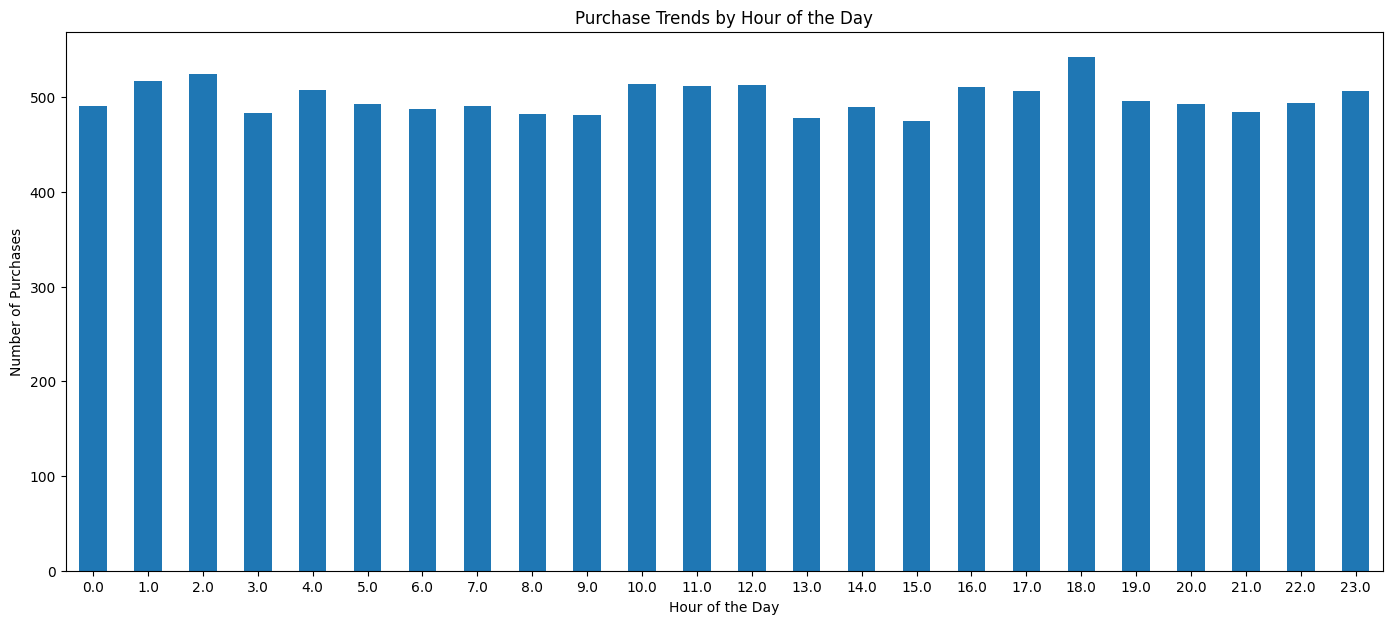

In [100]:
# Increase the plot size
plt.figure(figsize=(17, 7))  # Width = 20 inches, Height = 6 inches


# Plot the value counts as a bar plot
trends_hour_of_day_df["MOST_COMMON_HOUR_OF_THE_DAY_TO_PURCHASE"].value_counts().sort_index().plot(kind="bar")


# Customize the plot
plt.title("Purchase Trends by Hour of the Day")
plt.xlabel("Hour of the Day")
plt.ylabel("Number of Purchases")
plt.xticks(rotation=0)

plt.show()

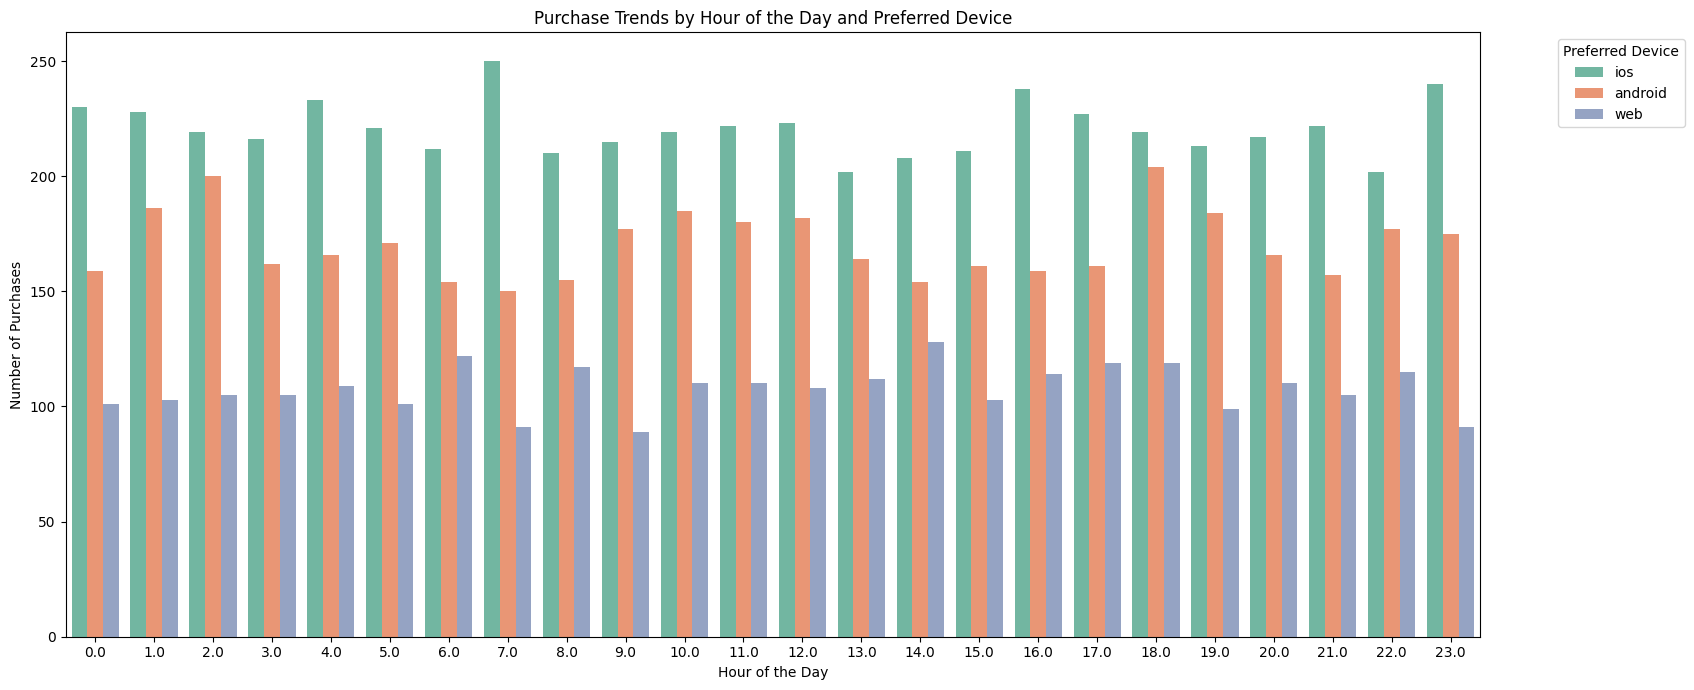

In [101]:
import seaborn as sns


# Increase the plot size
plt.figure(figsize=(17, 7))  # Width = 17 inches, Height = 7 inches

sns.countplot(
    x='MOST_COMMON_HOUR_OF_THE_DAY_TO_PURCHASE',
    hue='PREFERRED_DEVICE',
    data=trends_hour_of_day_df,
    palette='Set2'
)

plt.xlabel("Hour of the Day")
plt.ylabel("Number of Purchases")
plt.title("Purchase Trends by Hour of the Day and Preferred Device")
plt.xticks(rotation=0)
plt.legend(title='Preferred Device', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

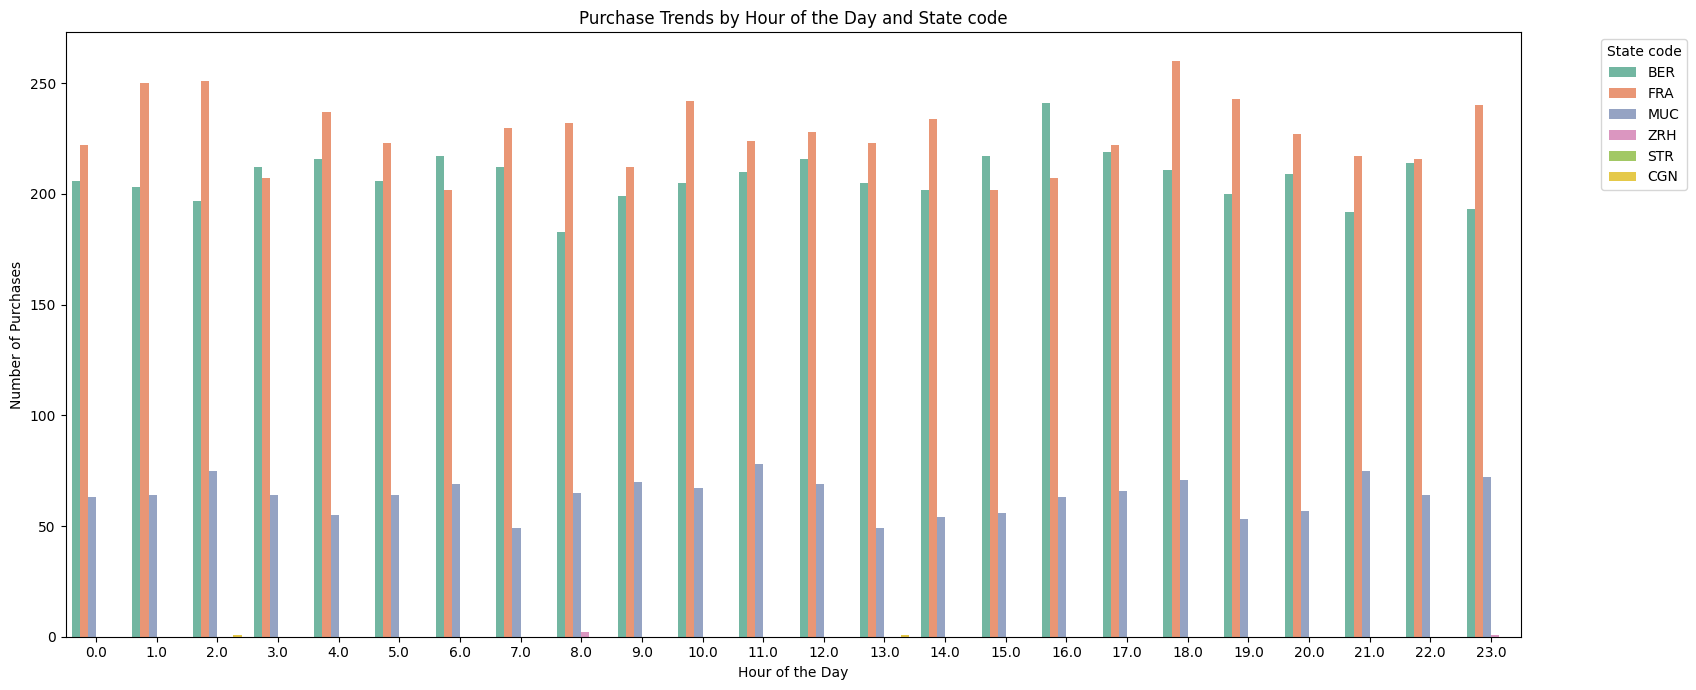

In [102]:

# Increase the plot size
plt.figure(figsize=(17, 7))  # Width = 17 inches, Height = 7 inches

sns.countplot(
    x='MOST_COMMON_HOUR_OF_THE_DAY_TO_PURCHASE',
    hue='REGISTRATION_STATE_CGNDE',
    data=trends_hour_of_day_df,
    palette='Set2'
)

plt.xlabel("Hour of the Day")
plt.ylabel("Number of Purchases")
plt.title("Purchase Trends by Hour of the Day and State code")
plt.xticks(rotation=0)
plt.legend(title='State code', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## b. Day of the week

In [103]:
trends_weekday_df = clean_dataset[["MOST_COMMON_WEEKDAY_TO_PURCHASE", "REGISTRATION_STATE_CGNDE", "PREFERRED_DEVICE"]]
trends_weekday_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21423 entries, 0 to 21427
Data columns (total 3 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   MOST_COMMON_WEEKDAY_TO_PURCHASE  11973 non-null  float64
 1   REGISTRATION_STATE_CGNDE         21423 non-null  object 
 2   PREFERRED_DEVICE                 21359 non-null  object 
dtypes: float64(1), object(2)
memory usage: 669.5+ KB


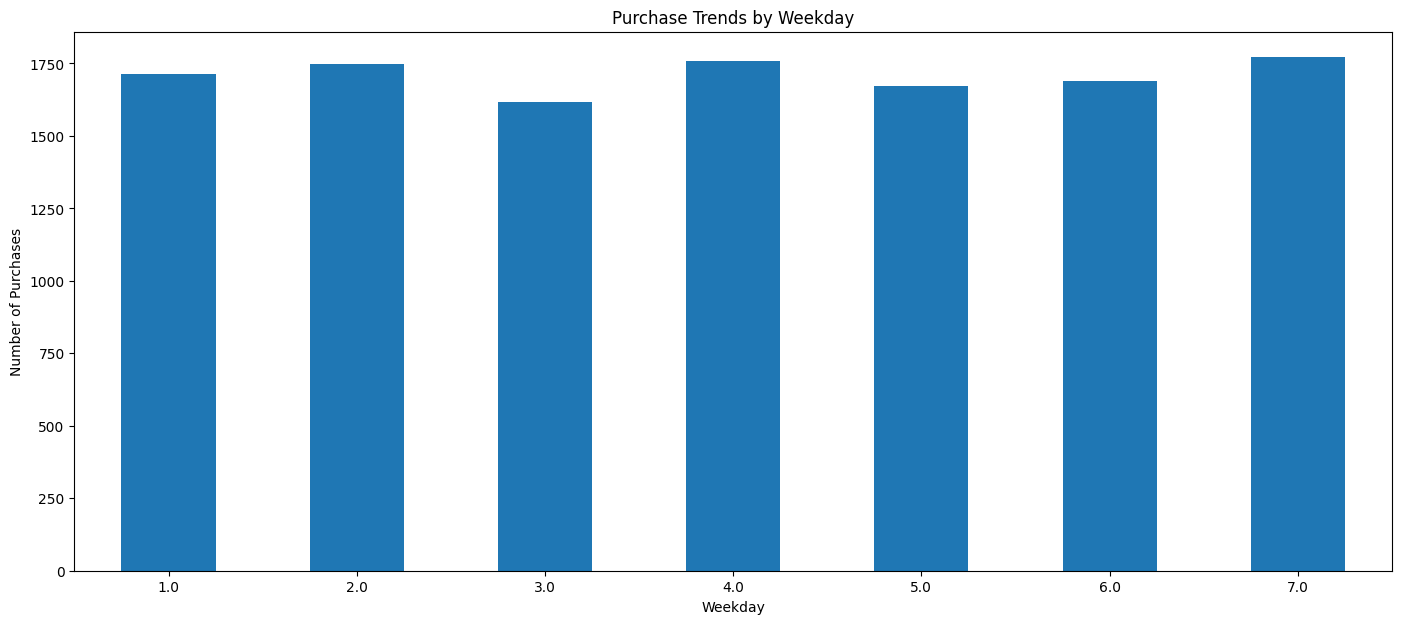

In [104]:
# Increase the plot size
plt.figure(figsize=(17, 7))  # Width = 20 inches, Height = 6 inches


# Plot the value counts as a bar plot
trends_weekday_df["MOST_COMMON_WEEKDAY_TO_PURCHASE"].value_counts().sort_index().plot(kind="bar")


# Customize the plot
plt.title("Purchase Trends by Weekday")
plt.xlabel("Weekday")
plt.ylabel("Number of Purchases")
plt.xticks(rotation=0)

plt.show()

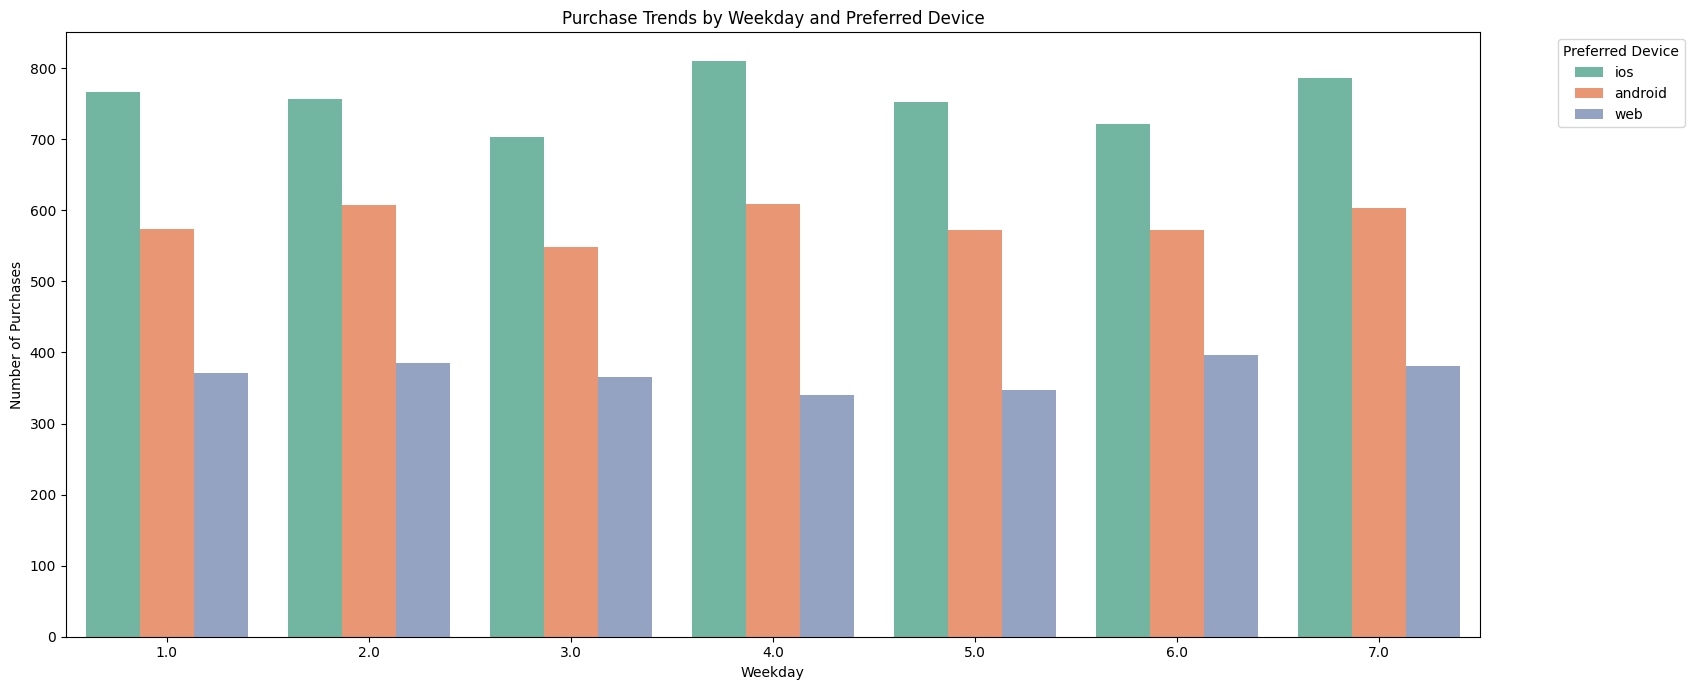

In [105]:
import seaborn as sns


# Increase the plot size
plt.figure(figsize=(17, 7))  # Width = 17 inches, Height = 7 inches

sns.countplot(
    x='MOST_COMMON_WEEKDAY_TO_PURCHASE',
    hue='PREFERRED_DEVICE',
    data=trends_weekday_df,
    palette='Set2'
)

plt.xlabel("Weekday")
plt.ylabel("Number of Purchases")
plt.title("Purchase Trends by Weekday and Preferred Device")
plt.xticks(rotation=0)
plt.legend(title='Preferred Device', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

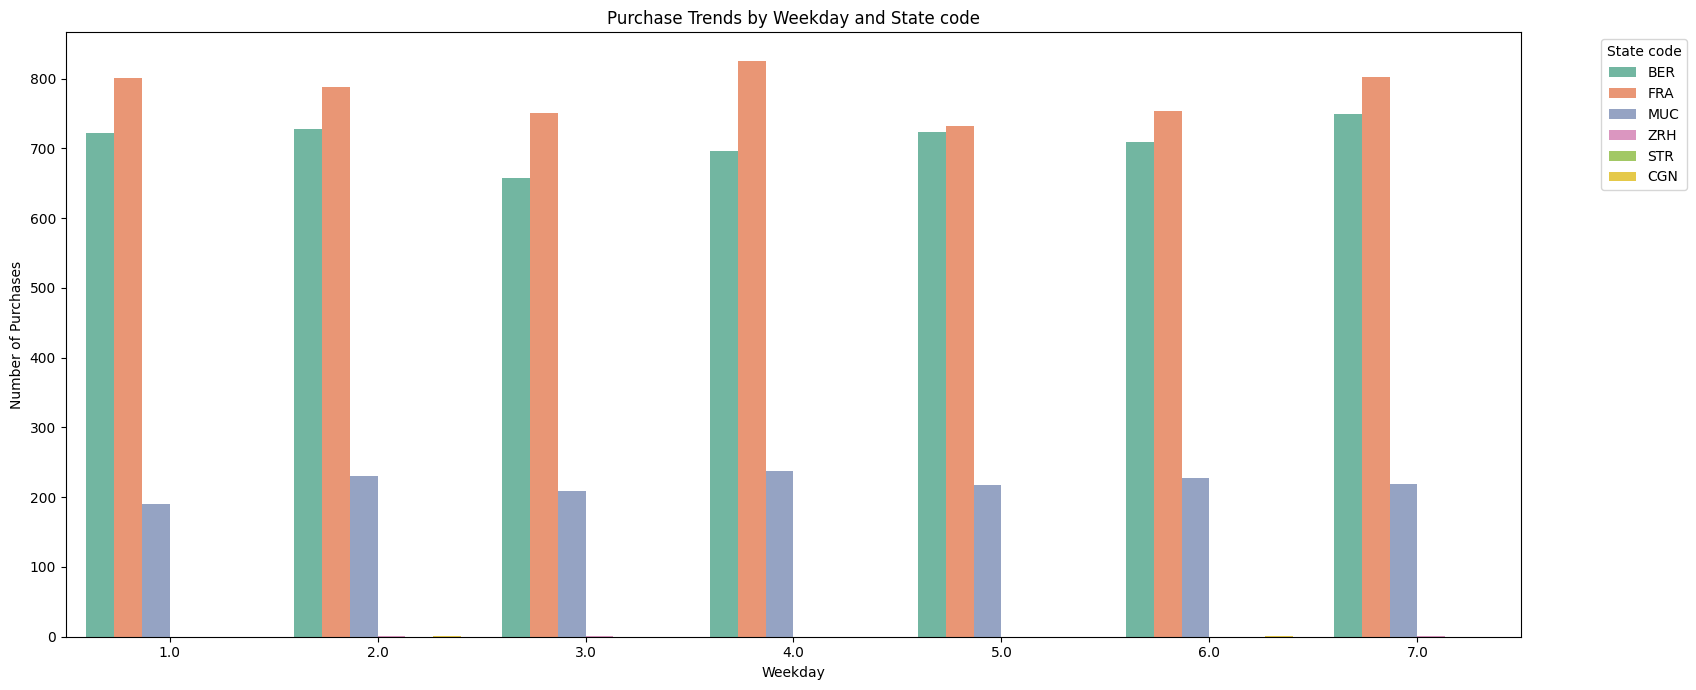

In [106]:
# Increase the plot size
plt.figure(figsize=(17, 7))  # Width = 17 inches, Height = 7 inches

sns.countplot(
    x='MOST_COMMON_WEEKDAY_TO_PURCHASE',
    hue='REGISTRATION_STATE_CGNDE',
    data=trends_weekday_df,
    palette='Set2'
)

plt.xlabel("Weekday")
plt.ylabel("Number of Purchases")
plt.title("Purchase Trends by Weekday and State code")
plt.xticks(rotation=0)
plt.legend(title='State code', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## c. Days between first and last purchase

In [109]:
# Convert date column to datetime type
clean_dataset["FIRST_PURCHASE"] = pd.to_datetime(clean_dataset["FIRST_PURCHASE"])
clean_dataset["LAST_PURCHASE"] = pd.to_datetime(clean_dataset["LAST_PURCHASE"])

In [110]:

#Extract date and time from the columns
clean_dataset["FIRST_PURCHASE_DATE"] = clean_dataset["FIRST_PURCHASE"].dt.date
clean_dataset["FIRST_PURCHASE_TIME"] = clean_dataset["FIRST_PURCHASE"].dt.time
clean_dataset["LAST_PURCHASE_DATE"] = clean_dataset["LAST_PURCHASE"].dt.date
clean_dataset["LAST_PURCHASE_TIME"] = clean_dataset["LAST_PURCHASE"].dt.time

In [111]:
# Ensure the columns are converted to datetime
clean_dataset['FIRST_PURCHASE_DATE'] = pd.to_datetime(clean_dataset['FIRST_PURCHASE_DATE'], errors='coerce')
clean_dataset['LAST_PURCHASE_DATE'] = pd.to_datetime(clean_dataset['LAST_PURCHASE_DATE'], errors='coerce')

# Calculate the difference in days
clean_dataset['LAST_FIRST_DIFF'] = (clean_dataset['LAST_PURCHASE_DATE'] - clean_dataset['FIRST_PURCHASE_DATE']).dt.days

In [112]:
clean_dataset['LAST_FIRST_DIFF'].value_counts().head(10)

LAST_FIRST_DIFF
0.0      4191
1.0       100
2.0        73
399.0      56
398.0      55
403.0      55
390.0      55
396.0      55
391.0      52
397.0      51
Name: count, dtype: int64

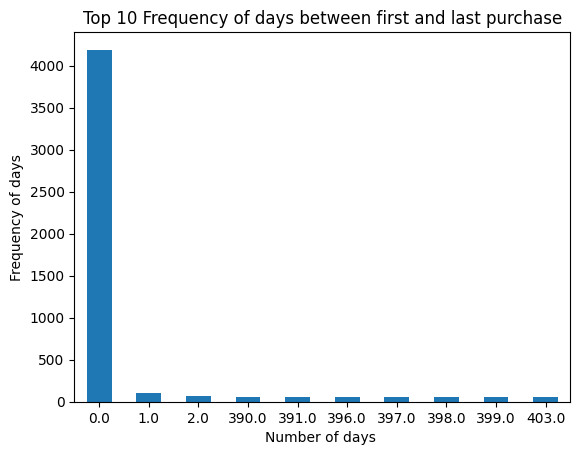

In [131]:
# Plot the value counts as a bar plot
clean_dataset['LAST_FIRST_DIFF'].value_counts().head(10).sort_index().plot(kind="bar")


# Customize the plot
plt.title("Top 10 Frequency of days between first and last purchase")
plt.xlabel("Number of days ")
plt.ylabel("Frequency of days")
plt.xticks(rotation=0)

plt.show()

In [133]:
# Define custom bin edges and labels
bins = [0, 1, 11, 51, float('inf')]  # Edge definitions for intervals [0], [1-10), [11-50), [51+]
labels = ['Same Day', 'Early', 'medium', 'Late']

# Create a new column 'Interval_Label' based on the intervals defined
clean_dataset['LAST_FIRST_DIFF_CAT'] = pd.cut(clean_dataset['LAST_FIRST_DIFF'], bins=bins, labels=labels, right=False)

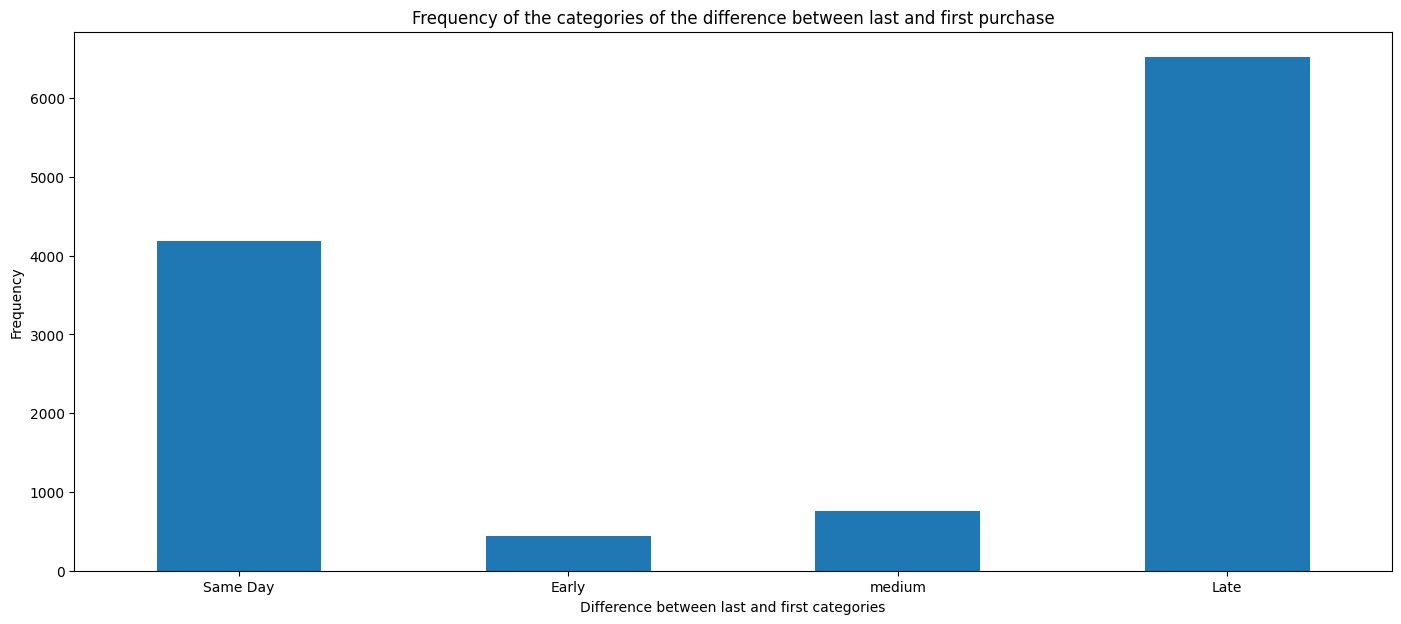

In [134]:
# Increase the plot size
plt.figure(figsize=(17, 7))  # Width = 17 inches, Height = 7 inches


# Plot the value counts as a bar plot
clean_dataset["LAST_FIRST_DIFF_CAT"].value_counts().sort_index().plot(kind="bar")


# Customize the plot
plt.title("Frequency of the categories of the difference between last and first purchase")
plt.xlabel("Difference between last and first categories")
plt.ylabel("Frequency")
plt.xticks(rotation=0)

plt.show()

## Purchase value

In [135]:
clean_dataset["PURCHASE_TOTAL_EUR"].min()

1.012

In [136]:
clean_dataset["PURCHASE_TOTAL_EUR"].max()

7979.62

In [139]:
# Define custom bin edges and labels
bins = [1, 51, 501, 1001, 5001, float('inf')]  # Edge definitions for intervals [0], [1-10), [11-50), [51+]
labels = ["very low", "low", "medium", "high", "very high"]


# Define bin definitions for annotation
bin_definitions = {
    'very low': '1 - 50',
    'low': '51 - 500',
    'medium': '501 - 1000',
    'high': '1001 - 5000',
    'very high': '5001+'
}




# Create a new column 'Interval_Label' based on the intervals defined
clean_dataset['TOTAL_PURCHASE_CAT'] = pd.cut(clean_dataset['PURCHASE_TOTAL_EUR'], bins=bins, labels=labels, right=False)

In [140]:
# Calculate the counts of each Total Purchase Catergory label
total_pur_cat_counts = clean_dataset['TOTAL_PURCHASE_CAT'].value_counts().sort_index()

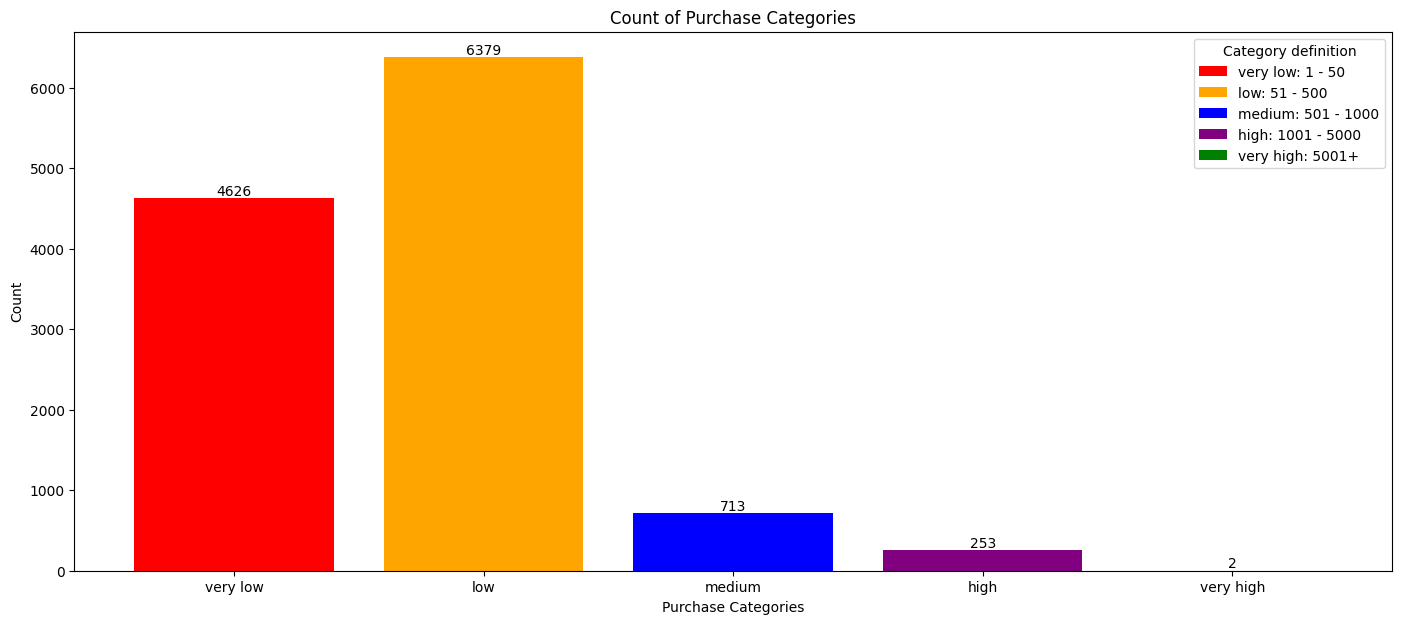

In [141]:
# Increase the plot size
plt.figure(figsize=(17, 7))  # Width = 17 inches, Height = 7 inches

# Assign colors for each label
colors = ["red", "orange", "blue", "purple", "green"]

# Plot the bar chart
bars = plt.bar(total_pur_cat_counts.index, total_pur_cat_counts.values, color=colors)


# Create a custom legend
# Create a legend by associating each bar with its bin definition
for bar, label in zip(bars, labels):
    bar.set_label(f"{label}: {bin_definitions[label]}")

# Display the legend
plt.legend(title="Category definition")


# Annotate the bars with the count at the top
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 5, int(yval), ha='center', va='bottom')


# # Annotate the bars with bin definitions
# for bar, bin_def in zip(bars, bin_definitions):
#     yval = bar.get_height()
#     plt.text(bar.get_x() + bar.get_width()/2, yval + 0.1, bin_def, ha='center', va='bottom')

# Set labels and title
plt.xlabel('Purchase Categories')
plt.ylabel('Count')
plt.title('Count of Purchase Categories')
plt.show()

## Average Order Value (AOV)

In [120]:
clean_dataset["AVERAGE_ORDER_VALUE"] = clean_dataset["PURCHASE_TOTAL_EUR"] / clean_dataset["DISTINCT_PURCHASE_COUNT"]

In [121]:
clean_dataset["AVERAGE_ORDER_VALUE"].min()

1.012

In [122]:
clean_dataset["AVERAGE_ORDER_VALUE"].max()

1743.676

In [123]:
# Define custom bin edges and labels
bins = [1, 101, 501, float('inf')]  # Edge definitions for intervals [0], [1-10), [11-50), [51+]
labels = ["low", "medium", "high"]


# Define bin definitions for annotation
bin_definitions = {
    'low': '1 - 100',
    'medium': '101 - 500',
    'high': '500+'
}



# Create a new column 'Interval_Label' based on the intervals defined
clean_dataset['AOV_CAT'] = pd.cut(clean_dataset['AVERAGE_ORDER_VALUE'], bins=bins, labels=labels, right=False)

In [124]:
# Calculate the counts of each Total Purchase Catergory label
aov_cat_counts = clean_dataset['AOV_CAT'].value_counts().sort_index()

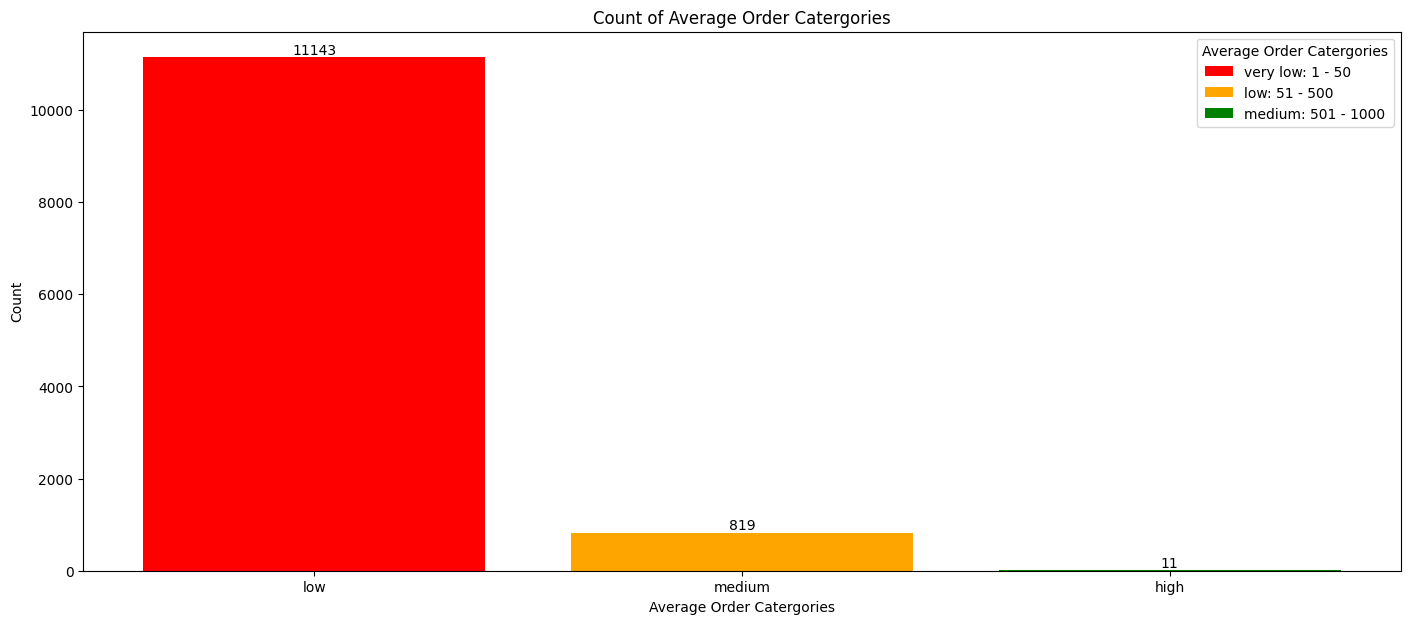

In [143]:
# Increase the plot size
plt.figure(figsize=(17, 7))  # Width = 17 inches, Height = 7 inches

# Assign colors for each label
colors = ["red", "orange", "green"]

# Plot the bar chart
bars = plt.bar(aov_cat_counts.index, aov_cat_counts.values, color=colors)


# Create a custom legend
# Create a legend by associating each bar with its bin definition
for bar, label in zip(bars, labels):
    bar.set_label(f"{label}: {bin_definitions[label]}")

# Display the legend
plt.legend(title="Average Order Catergories")


# Annotate the bars with the count at the top
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 5, int(yval), ha='center', va='bottom')



# Set labels and title
plt.xlabel('Average Order Catergories')
plt.ylabel('Count')
plt.title('Count of Average Order Catergories')
plt.show()

## Least Likely to Purchase in the Following Month

Identify customers whose LAST_PURCHASE is older than their average purchase interval (AVG_DAYS_BETWEEN_PURCHASES) and who do not have a valid payment method (HAS_VALID_PAYMENT_METHOD).

In [127]:
least_likely_to_pur = clean_dataset[clean_dataset["LAST_FIRST_DIFF"] < clean_dataset["AVG_DAYS_BETWEEN_PURCHASES"]]
least_likely_to_pur = least_likely_to_pur[least_likely_to_pur["HAS_VALID_PAYMENT_METHOD"] == False] 

In [128]:
least_likely_to_pur.shape[0]

251

## Most Likely to Purchase in a Marketing Campaign

1. Identify customers with a recent LAST_PURCHASE, high PURCHASE_COUNT_DELIVERY, and diverse purchase categories (MISC_PURCHASES, HOME_PURCHASES, etc.).

2. Factor in preferred device (PREFERRED_DEVICE) to target with specific campaigns (e.g., iOS, Android, Web).

3. Prioritize customers with a valid payment method (HAS_VALID_PAYMENT_METHOD).

In [144]:
# Filter the dataset to include only customers with the most recent purchase date.
# Importance: Recent activity is a strong indicator of customer engagement. Customers who have made a purchase recently are more likely to respond to marketing efforts since they have shown recent interest in the products or services.
market_campaign_df = clean_dataset[clean_dataset["LAST_PURCHASE_DATE"] == clean_dataset["LAST_PURCHASE_DATE"].max()]

# Further filter to include only customers who have made more than 5 deliveries.
# Importance: High purchase frequency suggests a habit of regular purchasing. These customers are more likely to continue purchasing if prompted by a marketing campaign, as they have already demonstrated frequent buying behavior.
market_campaign_df = market_campaign_df[market_campaign_df["PURCHASE_COUNT_DELIVERY"] > 5]

# Filter the dataset to include only customers who have a valid payment method.
# Importance: Having a valid payment method removes barriers to purchasing. Customers with a valid payment method are ready to make immediate purchases, increasing the likelihood of conversion when targeted by a marketing campaign.
market_campaign_df = market_campaign_df[market_campaign_df["HAS_VALID_PAYMENT_METHOD"] == True]

# Further filter to include only customers who fall into the 'very_high' or 'high' total purchase categories.
# Importance: Customers in these categories have shown significant spending power. Targeting them increases the chances of generating higher revenue from the marketing campaign, as they have a history of making substantial purchases.
market_campaign_df = market_campaign_df[market_campaign_df["TOTAL_PURCHASE_CAT"].isin(["very_high", "high"])]

# Finally, filter to include only customers with a 'high' average order value.
# Importance: A high average order value (AOV) indicates that the customer tends to make larger purchases per order. These customers are valuable targets for a marketing campaign because they are likely to spend more on each transaction, maximizing the campaign's ROI.
market_campaign_df = market_campaign_df[market_campaign_df["AOV_CAT"] == "high"]

In [145]:
market_campaign_df.shape

(1, 31)